## Package

In [4]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from kan import KAN


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [14]:
# Transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
DATA_PATH="/Users/asmitganguly/Developer/internships/UWaterloo-24/code/model/kan/ConvolutionalKANs/data"
# Cargar MNIST y filtrar por dos clases
mnist_train = MNIST(root=DATA_PATH, train=True, download=False, transform=transform)

mnist_test = MNIST(root=DATA_PATH, train=False, download=False, transform=transform)

# DataLoader
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

## Train & Test

In [15]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    """
    Train the model for one epoch

    Args:
        model: the neural network model
        device: cuda or cpu
        train_loader: DataLoader for training data
        optimizer: the optimizer to use (e.g. SGD)
        epoch: the current epoch
        criterion: the loss function (e.g. CrossEntropy)

    Returns:
        avg_loss: the average loss over the training set
    """

    model.to(device)
    model.train()
    train_loss = 0
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    # print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

def test(model, device, test_loader, criterion, all_result=False):
    """
    Test the model

    Args:
        model: the neural network model
        device: cuda or cpu
        test_loader: DataLoader for test data
        criterion: the loss function (e.g. CrossEntropy)

    Returns:
        test_loss: the average loss over the test set
        accuracy: the accuracy of the model on the test set
        precision: the precision of the model on the test set
        recall: the recall of the model on the test set
        f1: the f1 score of the model on the test set
    """

    model.eval()
    test_loss = 0
    correct = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += (target == predicted).sum().item()

            # Collect all targets and predictions for metric calculations
            all_targets.extend(target.view_as(predicted).cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate overall metrics
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')

    # Normalize test loss
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}\n'.format(
    #     test_loss, correct, len(test_loader.dataset), accuracy, precision, recall, f1))

    if all_result:
        # Calculate overall metrics
        precision = precision_score(all_targets, all_predictions)
        recall = recall_score(all_targets, all_predictions)
        f1 = f1_score(all_targets, all_predictions)
        return test_loss, correct, precision, recall, f1
    return test_loss, accuracy, precision, recall, f1

In [16]:
def train_and_test_models(model, device, train_loader, test_loader, optimizer, criterion, epochs, scheduler):
    """
    Train and test the model

    Args:
        model: the neural network model
        device: cuda or cpu
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        optimizer: the optimizer to use (e.g. SGD)
        criterion: the loss function (e.g. CrossEntropy)
        epochs: the number of epochs to train
        scheduler: the learning rate scheduler

    Returns:
        all_train_loss: a list of the average training loss for each epoch
        all_test_loss: a list of the average test loss for each epoch
        all_test_accuracy: a list of the accuracy for each epoch
        all_test_precision: a list of the precision for each epoch
        all_test_recall: a list of the recall for each epoch
        all_test_f1: a list of the f1 score for each epoch
    """
    # Track metrics
    all_train_loss = []
    all_test_loss = []
    all_test_accuracy = []
    all_test_precision = []
    all_test_recall = []
    all_test_f1 = []
    
    for epoch in range(1, epochs + 1):
        # Train the model
        train_loss = train(model, device, train_loader, optimizer, epoch, criterion)
        all_train_loss.append(train_loss)
        
        # Test the model
        test_loss, test_accuracy, test_precision, test_recall, test_f1 = test(model, device, test_loader, criterion)
        all_test_loss.append(test_loss)
        all_test_accuracy.append(test_accuracy)
        all_test_precision.append(test_precision)
        all_test_recall.append(test_recall)
        all_test_f1.append(test_f1)

        print(f'End of Epoch {epoch}: Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}')
        scheduler.step()
    model.all_test_accuracy = all_test_accuracy
    model.all_test_precision = all_test_precision
    model.all_test_f1 = all_test_f1
    model.all_test_recall = all_test_recall

    return all_train_loss, all_test_loss, all_test_accuracy, all_test_precision, all_test_recall, all_test_f1

## Set Device

In [17]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [18]:
device

device(type='mps')

## Common Models:
- SimpleCNN
- SimpleLinear
- ConvNet

In [19]:
EPOCH=10

In [20]:
import torch.nn.functional as F
class NormalConvsKAN(nn.Module):
    def __init__(self):
        super(NormalConvsKAN, self).__init__()
        # Convolutional layer, assuming an input with 1 channel (grayscale image)
        # and producing 16 output channels, with a kernel size of 3x3
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5, padding=1)
        self.conv3 = nn.Conv2d(10, 20, kernel_size=7, padding=1)
        # self.conv4 = nn.Conv2d(20, 40, kernel_size=9, padding=1)
        # self.conv5 = nn.Conv2d(40, 50, kernel_size=11, padding=1)

        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        """self, width=None, grid=3, k=3, noise_scale=0.1, scale_base_mu=0.0, scale_base_sigma=1.0, base_fun=torch.nn.SiLU(), symbolic_enabled=True, bias_trainable=False, grid_eps=1.0, grid_range=[-1, 1], sp_trainable=True, sb_trainable=True, device='cpu', seed=0"""

        # KAN layer
        # self.kan1 = KANLinear(
        #     245,
        #     10,
        #     grid_size=10,
        #     spline_order=3,
        #     scale_noise=0.01,
        #     scale_base=1,
        #     scale_spline=1,
        #     base_activation=nn.SiLU,
        #     grid_eps=0.02,
        #     grid_range=[0,1])

        self.kan1 = KAN(
            width=[20,10],
            grid=10,
            k=3,
            noise_scale=0.01,
            scale_base_mu=1,
            scale_base_sigma=1,
            grid_eps=0.02,
            grid_range=[0,1])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        # print(x.shape)
        # x = F.relu(self.conv4(x))
        # x = self.maxpool(x)
        # x = F.relu(self.conv5(x))
        
        x = self.flatten(x)
        x = self.kan1(x)

        x = F.log_softmax(x, dim=1)
        return x



model = NormalConvsKAN()
out = model(torch.randn(1, 1, 28, 28))
print("out: ", out.shape)

checkpoint directory created: ./model
saving model version 0.0
out:  torch.Size([1, 10])


/Users/asmitganguly/miniconda3/envs/mlx/lib/python3.12/site-packages/kan/MultKAN.py:419: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1808.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/Users/asmitganguly/miniconda3/envs/mlx/lib/python3.12/site-packages/kan/MultKAN.py:429: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1808.)
  input_range = torch.std(preacts, dim=0) + 0.1
/Users/asmitganguly/miniconda3/envs/mlx/lib/python3.12/site-packages/kan/MultKAN.py:430: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor

In [21]:
model_Convs_and_KAN= NormalConvsKAN()
model_Convs_and_KAN.to(device)
optimizer_Convs_and_KAN = optim.AdamW(model_Convs_and_KAN.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_Convs_and_KAN = optim.lr_scheduler.ExponentialLR(optimizer_Convs_and_KAN, gamma=0.8)
criterion_Convs_and_KAN = nn.CrossEntropyLoss()

all_train_loss_Convs_and_KAN, all_test_loss_Convs_and_KAN, all_test_accuracy_Convs_and_KAN, all_test_precision_Convs_and_KAN, all_test_recall_Convs_and_KAN, all_test_f1_Convs_and_KAN = train_and_test_models(model_Convs_and_KAN, device, train_loader, test_loader, optimizer_Convs_and_KAN, criterion_Convs_and_KAN, epochs=EPOCH, scheduler=scheduler_Convs_and_KAN)
torch.save(model_Convs_and_KAN.state_dict(), "./weights/Convs_and_KAN_pykan.pth")

checkpoint directory created: ./model
saving model version 0.0


100%|██████████| 938/938 [03:06<00:00,  5.02it/s]


End of Epoch 1: Train Loss: 0.335084, Test Loss: 0.0013, Accuracy: 97.05%


100%|██████████| 938/938 [03:01<00:00,  5.16it/s]


End of Epoch 2: Train Loss: 0.079247, Test Loss: 0.0008, Accuracy: 98.31%


100%|██████████| 938/938 [03:01<00:00,  5.16it/s]


End of Epoch 3: Train Loss: 0.057554, Test Loss: 0.0007, Accuracy: 98.54%


100%|██████████| 938/938 [03:01<00:00,  5.18it/s]


End of Epoch 4: Train Loss: 0.047805, Test Loss: 0.0007, Accuracy: 98.54%


100%|██████████| 938/938 [03:02<00:00,  5.15it/s]


End of Epoch 5: Train Loss: 0.040491, Test Loss: 0.0006, Accuracy: 98.74%


100%|██████████| 938/938 [03:01<00:00,  5.16it/s]


End of Epoch 6: Train Loss: 0.036411, Test Loss: 0.0006, Accuracy: 98.80%


100%|██████████| 938/938 [03:01<00:00,  5.17it/s]


End of Epoch 7: Train Loss: 0.031758, Test Loss: 0.0005, Accuracy: 98.86%


100%|██████████| 938/938 [03:01<00:00,  5.18it/s]


End of Epoch 8: Train Loss: 0.028831, Test Loss: 0.0006, Accuracy: 98.84%


100%|██████████| 938/938 [03:08<00:00,  4.96it/s]


End of Epoch 9: Train Loss: 0.026880, Test Loss: 0.0005, Accuracy: 98.90%


100%|██████████| 938/938 [03:07<00:00,  5.01it/s]


End of Epoch 10: Train Loss: 0.025021, Test Loss: 0.0005, Accuracy: 98.94%


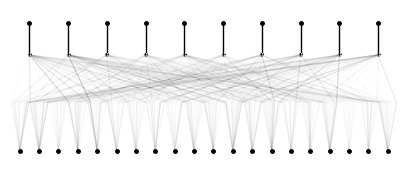

In [22]:
model_Convs_and_KAN.kan1.plot()

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model_Convs_and_KAN)

14930

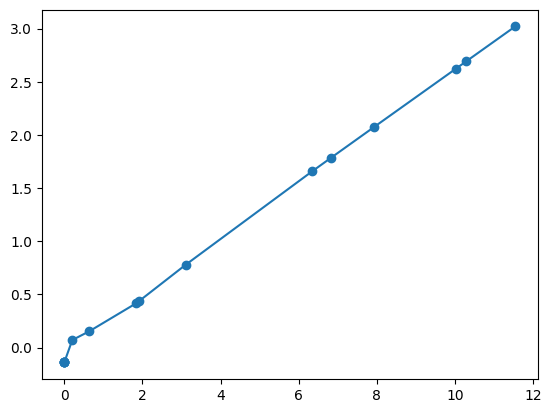

In [36]:
l = 0
i = 15
j = 9

model = model_Convs_and_KAN.kan1
inputs = model.spline_preacts[l][:,j,i].cpu()
outputs = model.spline_postacts[l][:,j,i].cpu()
# they are not ordered yet
rank = np.argsort(inputs)
inputs = inputs[rank]
outputs = outputs[rank]
plt.plot(inputs, outputs, marker="o")

## Load Test Plot

In [ ]:
def load_model(model_class, model_path, device):
    """
    Load a saved model from a file.

    Args:
        model_class: the class of the model to be loaded
        model_path: the path to the saved model file
        device: cuda or cpu

    Returns:
        model: the loaded model
    """
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model

def load_test_model(model_class, model_path, test_loader, criterion, device):
    """
    Load a saved model and test it.

    Args:
        model_class: the class of the model to be loaded
        model_path: the path to the saved model file
        test_loader: DataLoader for test data
        criterion: the loss function (e.g. CrossEntropy)
        device: cuda or cpu

    Returns:
        test_loss: the average loss over the test set
        accuracy: the accuracy of the model on the test set
        precision: the precision of the model on the test set
        recall: the recall of the model on the test set
        f1: the f1 score of the model on the test set
    """
    # Load the model
    model = load_model(model_class, model_path, device)

    # Test the model
    test_loss, accuracy, precision, recall, f1 = test(model, device, test_loader, criterion)

    return model, test_loss, accuracy, precision, recall, f1

: 

: 